<img src="../../images/BikeDNA_logo.svg" width="250"  alt="BikeDNA logo" style="display:block; margin-left: auto; margin-right: auto;">
<a href="https://github.com/anerv/BikeDNA">Github</a>

# 2b. Intrinsic Analysis of Reference Data

This notebook analyses the quality of a user-provided reference bicycle infrastructure data set for a given area. The quality assessment is *intrinsic*, i.e. based only on the one input data set, and making no use of information external to the data set. For an extrinsic quality assessment that compares the reference data set to corresponding OSM data, see the notebooks 3a and 3b.

The analysis assesses the *fitness for purpose* ([Barron et al., 2014](https://onlinelibrary.wiley.com/doi/10.1111/tgis.12073)) of the reference data for a given area. Outcomes of the analysis can be relevant for bicycle planning and research - especially for projects that include a network analysis of bicycle infrastructure, in which case the topology of the geometries is of particular importance.

Since the assessment does not make use of an external reference data set as the ground truth, no universal claims of data quality can be made. The idea is rather to enable those working with bicycle networks to assess whether their data are good enough for their particular use case. The analysis assists in finding potential data quality issues but leaves the final interpretation of the results to the user.

The notebook makes use of quality metrics from a range of previous projects investigating OSM/VGI data quality, such as [Ferster et al. (2020)](https://www.tandfonline.com/doi/full/10.1080/15568318.2018.1519746), [Hochmair et al. (2015)](https://onlinelibrary.wiley.com/doi/abs/10.1111/tgis.12081), [Barron et al. (2014)](https://onlinelibrary.wiley.com/doi/10.1111/tgis.12073), and [Neis et al. (2012](https://www.mdpi.com/1999-5903/4/1/1)).

<div class="alert alert-block alert-info">
<b>Prerequisites &amp; Input/Output</b>
<p>
Run notebook 1b in advance.  
    
Output files of this notebook (data, maps, plots) are saved to the <span style="font-family:courier;">../results/REFERENCE/[study_area]/</span> subfolders.
</p>
</div>

<div class="alert alert-block alert-info">
<b>Familiarity required</b>
<p>
For a correct interpretation of some of the metrics for spatial data quality, some familiarity with the area is necessary.
</p>
</div>

* [Data completeness](#Data-completeness)
    * [Network density](#Network-density)
* [Network topology](#Network-topology)
    * [Simplification outcome](#Simplification-outcome)
    * [Dangling nodes](#Dangling-nodes)
    * [Under/overshoots](#Under/overshoots)
* [Network components](#Network-components)
    * [Disconnected components](#Disconnected-components)
    * [Components per grid cell](#Components-per-grid-cell)
    * [Component length distribution](#Component-length-distribution)
    * [Largest connected component](#Largest-connected-component)
    * [Missing links](#Missing-links)
    * [Component connectivity](#Component-connectivity)
* [Summary](#Summary)

<br />

In [1]:
# Load libraries, settings and data

import json
import pickle
import warnings
from collections import Counter
import math

import contextily as cx
import folium
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import yaml
from matplotlib import cm, colors

from src import evaluation_functions as eval_func
from src import plotting_functions as plot_func

%run ../settings/yaml_variables.py
%run ../settings/plotting.py
%run ../settings/tiledict.py
%run ../settings/load_refdata.py
%run ../settings/df_styler.py
%run ../settings/paths.py

warnings.filterwarnings("ignore")

grid = ref_grid

/Users/anev/Library/CloudStorage/Dropbox/ITU/repositories/bikedna_denmark/scripts/settings/plotting.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, n)
/Users/anev/Library/CloudStorage/Dropbox/ITU/repositories/bikedna_denmark/scripts/settings/plotting.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


Reference graphs loaded successfully!
Reference data loaded successfully!


<string>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
<string>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


<div class="alert alert-block alert-info">
<b>User configurations</b>
<br>
<br>
For large datasets, the plotting can take as long as the actual analysis, if not more.
To allow for a faster execution of the notebook, use the above setting to control whether results are plotted or not.
</div>

In [2]:
# USER INPUT: SET PLOTTING OF STATIC AND INTERACTIVE MAPS TO TRUE OF FALSE
plot_static_maps = False
plot_interactive_maps = False

for s in [plot_static_maps, plot_interactive_maps]:
    assert isinstance(s, bool), print(
        "Settings must be True or False!"
    )

print(f"Running notebook with plotting setting for static maps set to: {plot_static_maps}")
print(f"Running notebook with plotting setting for interactive maps set to: {plot_interactive_maps}")

Running notebook with plotting setting for static maps set to: False
Running notebook with plotting setting for interactive maps set to: False


## Data completeness

### Network density

In this setting, network density refers to the length of edges or number of nodes per km2. This is the usual definition of network density in spatial (road) networks, which is distinct from the *structural* network density known more generally in network science. Without comparing to a reference data set, network density does not in itself indicate spatial data quality. For anyone familiar with the study area, network density can however indicate whether parts of the area appear to be under- or over-mapped.

**Method**

The density here is not based on the geometric length of edges, but instead on the computed length of the infrastructure. For example, a 100-meter-long bidirectional path contributes with 200 meters of bicycle infrastructure. This method is used to take into account different ways of mapping bicycle infrastructure, which otherwise can introduce large deviations in network density. With `compute_network_density`, the number of elements (nodes, dangling nodes, and total infrastructure length) per unit area is calculated. The density is computed twice: first for the study area for both the entire network ('global density'), then for each of the grid cells ('local density'). Both global and local densities are computed for the entire network and for protected and unprotected infrastructure.

**Interpretation**

Since the analysis conducted here is intrinsic, i.e. it makes no use of external information, it cannot be known whether a low-density value is due to incomplete mapping, or due to actual lack of infrastructure in the area. However, a comparison of the grid cell density values can provide some insights, for example:
* lower-than-average infrastructure density indicates a locally sparser network
* higher-than-average node density indicates that there are relatively many intersections in a grid cell
* higher-than-average dangling node density indicates that there are relatively many dead ends in a grid cell

#### Global network density

<br />

In [3]:
# Entire study area
edge_density, node_density, dangling_node_density = eval_func.compute_network_density(
    (ref_edges_simplified, ref_nodes_simplified),
    grid.unary_union.area,
    return_dangling_nodes=True,
)

density_results = {}
density_results["edge_density_m_sqkm"] = edge_density
density_results["node_density_count_sqkm"] = node_density
density_results["dangling_node_density_count_sqkm"] = dangling_node_density

ref_protected = ref_edges_simplified.loc[ref_edges_simplified.protected == "protected"]
ref_unprotected = ref_edges_simplified.loc[
    ref_edges_simplified.protected == "unprotected"
]
ref_mixed = ref_edges_simplified.loc[ref_edges_simplified.protected == "mixed"]

ref_data = [ref_protected, ref_unprotected, ref_mixed]
labels = ["protected_density", "unprotected_density", "mixed_density"]

for data, label in zip(ref_data, labels):
    if len(data) > 0:
        ref_edge_density_type, _ = eval_func.compute_network_density(
            (data, ref_nodes_simplified),
            grid.unary_union.area,
            return_dangling_nodes=False,
        )
        density_results[label + "_m_sqkm"] = ref_edge_density_type
    else:
        density_results[label + "_m_sqkm"] = 0

protected_edge_density = density_results["protected_density_m_sqkm"]
unprotected_edge_density = density_results["unprotected_density_m_sqkm"]
mixed_protection_edge_density = density_results["mixed_density_m_sqkm"]

print(f"For the entire study area, there are:")
print(f"- {edge_density:.2f} meters of bicycle infrastructure per km2.")
print(f"- {node_density:.2f} nodes in the bicycle network per km2.")
print(
    f"- {dangling_node_density:.2f} dangling nodes in the bicycle network per km2."
)
print(
    f"- {protected_edge_density:.2f} meters of protected bicycle infrastructure per km2."
)
print(
    f"- {unprotected_edge_density:.2f} meters of unprotected bicycle infrastructure per km2."
)
print(
    f"- {mixed_protection_edge_density:.2f} meters of mixed protection bicycle infrastructure per km2."
)

For the entire study area, there are:
- 187.30 meters of bicycle infrastructure per km2.
- 1.11 nodes in the bicycle network per km2.
- 0.24 dangling nodes in the bicycle network per km2.
- 92.05 meters of protected bicycle infrastructure per km2.
- 95.25 meters of unprotected bicycle infrastructure per km2.
- 0.00 meters of mixed protection bicycle infrastructure per km2.


In [4]:
# Save stats to csv
pd.DataFrame(
    {
        "metric": [
            "meters of bicycle infrastructure per square km",
            "nodes in the bicycle network per square km",
            "dangling nodes in the bicycle network per square km",
            "meters of protected bicycle infrastructure per square km",
            "meters of unprotected bicycle infrastructure per square km",
            "meters of mixed protection bicycle infrastructure per square km",
        ],
        "value": [
            np.round(edge_density, 2),
            np.round(node_density, 2),
            np.round(dangling_node_density, 2),
            np.round(protected_edge_density, 2),
            np.round(unprotected_edge_density, 2),
            np.round(mixed_protection_edge_density, 2),
        ],
    }
).to_csv(ref_results_data_fp + "stats_area.csv", index=False)

#### Local network density

In [5]:
# Per grid cell
results_dict = {}
data = (ref_edges_simp_joined, ref_nodes_simp_joined.set_index("osmid"))

[
    eval_func.run_grid_analysis(
        grid_id,
        data,
        results_dict,
        eval_func.compute_network_density,
        grid["geometry"].loc[grid.grid_id == grid_id].area.values[0],
        return_dangling_nodes=True,
    )
    for grid_id in grid_ids
]

results_df = pd.DataFrame.from_dict(results_dict, orient="index")
results_df.reset_index(inplace=True)
results_df.rename(
    columns={
        "index": "grid_id",
        0: "ref_edge_density",
        1: "ref_node_density",
        2: "ref_dangling_node_density",
    },
    inplace=True,
)

grid = eval_func.merge_results(grid, results_df, "left")

ref_protected = ref_edges_simp_joined.loc[
    ref_edges_simp_joined.protected == "protected"
]
ref_unprotected = ref_edges_simp_joined.loc[
    ref_edges_simp_joined.protected == "unprotected"
]
ref_mixed = ref_edges_simp_joined.loc[ref_edges_simp_joined.protected == "mixed"]

ref_data = [ref_protected, ref_unprotected, ref_mixed]

ref_labels = ["ref_protected_density", "ref_unprotected_density", "ref_mixed_density"]

for data, label in zip(ref_data, ref_labels):
    if len(data) > 0:
        results_dict = {}
        data = (ref_edges_simp_joined.loc[data.index], ref_nodes_simp_joined)
        [
            eval_func.run_grid_analysis(
                grid_id,
                data,
                results_dict,
                eval_func.compute_network_density,
                grid["geometry"].loc[grid.grid_id == grid_id].area.values[0],
            )
            for grid_id in grid_ids
        ]

        results_df = pd.DataFrame.from_dict(results_dict, orient="index")
        results_df.reset_index(inplace=True)
        results_df.rename(columns={"index": "grid_id", 0: label}, inplace=True)
        results_df.drop(1, axis=1, inplace=True)

        grid = eval_func.merge_results(grid, results_df, "left")

In [6]:
# Network density grid plots

if plot_static_maps:

    set_renderer(renderer_map)
    plot_cols = ["ref_edge_density", "ref_node_density", "ref_dangling_node_density"]
    plot_titles = [
        area_name + f": {reference_name} edge density",
        area_name + f": {reference_name} node density",
        area_name + f": {reference_name} dangling node density",
    ]
    filepaths = [
        ref_results_static_maps_fp + "density_edge_reference",
        ref_results_static_maps_fp + "density_node_reference",
        ref_results_static_maps_fp + "density_danglingnode_reference",
    ]
    cmaps = [pdict["pos"], pdict["pos"], pdict["pos"]]
    no_data_cols = ["count_ref_edges", "count_ref_nodes", "count_ref_nodes"]

    plot_func.plot_grid_results(
        grid=grid,
        plot_cols=plot_cols,
        plot_titles=plot_titles,
        filepaths=filepaths,
        cmaps=cmaps,
        alpha=pdict["alpha_grid"],
        cx_tile=cx_tile_2,
        no_data_cols=no_data_cols,
        attr=reference_name
    )

#### Densities of protected and unprotected infrastructure

In BikeDNA, *protected infrastructure* refers to all bicycle infrastructure which is either separated from car traffic by for example an elevated curb, bollards, or other physical barriers, or for cycle tracks that are not adjacent to a street.

*Unprotected infrastructure* are all other types of lanes that are dedicated for bicyclists, but which only are separated by car traffic by e.g., a painted line on the street.

In [7]:
# Network density grid plots

if plot_static_maps:

    set_renderer(renderer_map)
    plot_cols = ["ref_protected_density", "ref_unprotected_density", "ref_mixed_density"]

    plot_cols = [p for p in plot_cols if p in grid.columns]

    plot_titles = [
        area_name + f": {reference_name} protected infrastructure density (m/km2)",
        area_name + f": {reference_name} unprotected infrastructure density (m/km2)",
        area_name + f": {reference_name} mixed protection infrastructure density (m/km2)"
    ]


    filepaths = [
        ref_results_static_maps_fp + "density_protected_reference",
        ref_results_static_maps_fp + "density_unprotected_reference",
        ref_results_static_maps_fp + "density_mixed_reference",
    ]

    cmaps = [pdict["pos"]] * len(plot_cols)
    no_data_cols = ["ref_protected_density", "ref_unprotected_density", "ref_mixed_density"]
    norm_min = [0] * len(plot_cols)
    norm_max = [max(grid[plot_cols].fillna(value=0).max())] * len(plot_cols)

    plot_func.plot_grid_results(
        grid=grid,
        plot_cols=plot_cols,
        plot_titles=plot_titles,
        filepaths=filepaths,
        cmaps=cmaps,
        alpha=pdict["alpha_grid"],
        cx_tile=cx_tile_2,
        no_data_cols=no_data_cols,
        use_norm=True,
        norm_min=norm_min,
        norm_max=norm_max,
        attr=reference_name
    )

## Network topology

This section explores the geometric and topological features of the data. These are, for example, network density, disconnected components, and dangling (degree one) nodes. It also includes exploring whether there are nodes that are very close to each other but do not share an edge - a potential sign of edge undershoots - or if there are intersecting edges without a node at the intersection, which might indicate a digitizing error that will distort routing on the network.

Due to the fragmented nature of most bicycle networks, many metrics, such as missing links or network gaps, can simply reflect the true extent of the infrastructure ([Natera Orozco et al., 2020](https://onlinelibrary.wiley.com/doi/pdfdirect/10.1111/gean.12324)). This is different for road networks, where e.g., disconnected components could more readily be interpreted as a data quality issue. Therefore, the analysis only takes very small network gaps into account as potential data quality issues.

### Simplification outcome

To compare the structure and true ratio between nodes and edges in the network, a simplified network representation which only includes nodes at endpoints and intersections was created in notebook `1b` by removing all interstitial nodes.

Comparing the degree distribution for the networks before and after simplification is a quick sanity check for the simplification routine. Typically, the vast majority of nodes in the non-simplified network will be of degree two; in the simplified network, however, most nodes will have degrees other than two. Degree two nodes are retained in only two cases: if they represent a connection point between two different types of infrastructure; or if they are needed in order to avoid self-loops (edges whose start and end points are identical) or multiple edges between the same pair of nodes. 

<p align="center">
<img src='../../images/network_simplification_illustration.png' width=300/>

*Non-simplified network (left) and simplified network (right)*.

</p>

**Method**

The node degree distributions before and after simplification are plotted below. 

**Interpretation**

Typically, the node degree distribution will go from high (before simplification) to low (after simplification) counts of degree two nodes, while it will not change for all other degrees (1, or 3 and higher). Further, the total number of nodes will see a strong decline. If the simplified graph still maintains a relatively high number of degree two nodes, or if the number of nodes with other degrees changes after the simplification, this might point to issues either with the graph conversion or with the simplification process.

<br />

In [8]:
# Decrease in network elements after simplification

edge_percent_diff = (len(ref_edges) - len(ref_edges_simplified)) / len(ref_edges) * 100
node_percent_diff = (len(ref_nodes) - len(ref_nodes_simplified)) / len(ref_nodes) * 100

simplification_results = {
    "edge_percent_diff": edge_percent_diff,
    "node_percent_diff": node_percent_diff,
}

print(
    f"Simplifying the network decreased the number of edges with {edge_percent_diff:.1f}% and the number of nodes with {node_percent_diff:.1f}%."
)

Simplifying the network decreased the number of edges with 92.3% and the number of nodes with 92.3%.


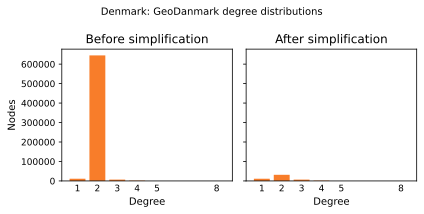

In [9]:
# Node degree distribution

set_renderer(renderer_plot)
fig, ax = plt.subplots(1, 2, figsize=pdict["fsbar_short"], sharey=True)

degree_sequence_before = sorted((d for n, d in ref_graph.degree()), reverse=True)
degree_sequence_after = sorted(
    (d for n, d in ref_graph_simplified.degree()), reverse=True
)


ax[0].bar(*np.unique(degree_sequence_before, return_counts=True), tick_label = np.unique(degree_sequence_before), color=pdict["ref_base"])
ax[0].set_title("Before simplification")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Nodes")

ax[1].bar(*np.unique(degree_sequence_after, return_counts=True), tick_label = np.unique(degree_sequence_after), color=pdict["ref_base"])
ax[1].set_title("After simplification")
ax[1].set_xlabel("Degree")

plt.suptitle(f"{area_name}: {reference_name} degree distributions")

fig.tight_layout()

plot_func.save_fig(fig, ref_results_plots_fp + "degree_dist_reference")
plt.show();

### Dangling nodes

Dangling nodes are nodes of degree one, i.e. they have only one single edge attached to them. Most networks will naturally contain a number of dangling nodes. Dangling nodes can occur at actual dead-ends (representing a cul-de-sac) or at the endpoints of certain features, e.g. when a bicycle path ends in the middle of a street. However, dangling nodes can also occur as a data quality issue in case of over/undershoots (see next section). The number of dangling nodes in a network does to some extent also depend on the digitization method, as shown in the illustration below. 

Therefore, the presence of dangling nodes is in itself not a sign of low data quality. However, a high number of dangling nodes in an area that is not known for containing many dead-ends can indicate digitization errors and problems with edge over/undershoots.

<!-- <table><tr><td><img src='../../images/dangling_nodes_illustration.png' width=300 /></td><td><img src='../../images/no_dangling_nodes_illustration.png' width=295 /></td></tr></table> -->

<p align="center">

<img src='../../images/dangling_nodes_illustration_new.png' width=350/>

*Left: Dangling nodes occur where road features end. Right: However, when separate features are joined at the end, there will be no dangling nodes.*

</p>

**Method**

Below, a list of all dangling nodes is obtained with the help of `get_dangling_nodes`. Then, the network with all its nodes is plotted. The dangling nodes are shown in color, all other nodes are shown in black.

**Interpretation**

We recommend a visual analysis in order to interpret the spatial distribution of dangling nodes, with particular attention to areas of high dangling node density. It is important to understand where dangling nodes come from: are they actual dead-ends or digitization errors (e.g., over/undershoots)? A higher number of digitization errors points to lower data quality.

<br />

In [10]:
# Compute number of dangling nodes
dangling_nodes = eval_func.get_dangling_nodes(
    ref_edges_simplified, ref_nodes_simplified
)

# Export results
dangling_nodes.to_file(ref_results_data_fp + "dangling_nodes.gpkg", index=False)

# Compute local count and pct of dangling nodes
dn_ref_joined = gpd.overlay(
    dangling_nodes, grid[["geometry", "grid_id"]], how="intersection"
)
df = eval_func.count_features_in_grid(dn_ref_joined, "ref_dangling_nodes")
grid = eval_func.merge_results(grid, df, "left")

grid["ref_dangling_nodes_pct"] = np.round(
    100 * grid.count_ref_dangling_nodes / grid.count_ref_simplified_nodes, 2
)

# set to zero where there are simplified nodes but no dangling nodes
grid["ref_dangling_nodes_pct"].loc[
    grid.count_ref_simplified_nodes.notnull() & grid.ref_dangling_nodes_pct.isnull()
] = 0

In [11]:
# Plot dangling nodes

if plot_static_maps:

    set_renderer(renderer_map)
    fig, ax = plt.subplots(1, figsize=pdict["fsmap"])

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3.5%", pad="1%")
        
    grid.plot(
        cax=cax,
        column="ref_dangling_nodes_pct",
        ax=ax,
        alpha=pdict["alpha_grid"],
        cmap=pdict["pos"],
        legend=True,
    )

    # add no data patches
    grid[grid["count_ref_simplified_nodes"].isnull()].plot(
        cax=cax,
        ax=ax,
        facecolor=pdict["nodata_face"],
        edgecolor=pdict["nodata_edge"],
        linewidth= pdict["line_nodata"],
        hatch=pdict["nodata_hatch"],
        alpha= pdict["alpha_nodata"],
    )

    ax.legend(handles=[nodata_patch], loc="upper right")
    ax.set_title(f"{area_name}: {reference_name} percent of dangling nodes")
    ax.set_axis_off()
    cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)
    cx.add_attribution(ax=ax, text=f"(C) {reference_name}")
    txt = ax.texts[-1]
    txt.set_position([1,0.00])
    txt.set_ha('right')
    txt.set_va('bottom')

    plot_func.save_fig(fig,ref_results_static_maps_fp + "pct_dangling_nodes_reference")

In [12]:
# Interactive plot of dangling nodes

if plot_interactive_maps:

    edges_simplified_folium = plot_func.make_edgefeaturegroup(
        gdf=ref_edges_simplified,
        mycolor=pdict["base"],
        myweight=pdict["line_base"],
        nametag="Edges",
        show_edges=True,
    )

    nodes_simplified_folium = plot_func.make_nodefeaturegroup(
        gdf=ref_nodes_simplified,
        mysize=pdict["mark_base"],
        mycolor=pdict["base"],
        nametag="All nodes",
        show_nodes=True,
    )

    dangling_nodes_folium = plot_func.make_nodefeaturegroup(
        gdf=dangling_nodes,
        mysize=pdict["mark_emp"],
        mycolor=pdict["ref_base"],
        nametag="Dangling nodes",
        show_nodes=True,
    )

    m = plot_func.make_foliumplot(
        feature_groups=[
            edges_simplified_folium,
            nodes_simplified_folium,
            dangling_nodes_folium,
        ],
        layers_dict=folium_layers,
        center_gdf=ref_nodes_simplified,
        center_crs=ref_nodes_simplified.crs,
        attr=reference_name
    )

    bounds = plot_func.compute_folium_bounds(ref_nodes_simplified)
    m.fit_bounds(bounds)


    m.save(ref_results_inter_maps_fp + "folium_danglingmap_reference.html")

    display(m)

In [13]:
if plot_interactive_maps:
    print("Interactive map saved at " + ref_results_inter_maps_fp.lstrip("../") + "folium_danglingmap_reference.html")

### Under/overshoots 

When two nodes in a simplified network are placed within a distance of a few meters, but do not share a common edge, it is often due to an edge over/undershoot or another digitizing error. An undershoot occurs when two features are supposed to meet, but instead are just in close proximity to each other. An overshoot occurs when two features meet and one of them extends beyond the other. See the image below for an illustration. For a more detailed explanation of over/undershoots, see the [GIS Lounge website](https://www.gislounge.com/digitizing-errors-in-gis/).

<!-- <table>
<tr><td><img src='../../images/undershoot_illustration.png' width=300 /></td><td><img src='../../images/overshoot_illustration.png' width=300  /></td></tr>
</table>

*Left: Undershoots happen when two line features are not properly joined, for example at intersection. Right: Overshoots refer to situations where a line feature extends too far beyond at intersecting line, rather than ending at the intersection.*  -->

<p align="center">

<img src='../../images/over_undershoots2.png' width=350/>

*Left: Undershoots happen when two line features are not properly joined, for example at an intersection. Right: Overshoots refer to situations where a line feature extends too far beyond at intersecting line, rather than ending at the intersection.* 

</p>

**Method**

*Undershoots:* First, the `length_tolerance` (in meters) is defined in the cell below. Then, with `find_undershoots`, all pairs of dangling nodes that have a maximum of `length_tolerance` distance between them, are identified as undershoots, and the results are plotted.

*Overshoots:* First, the `length_tolerance` (in meters) is defined in the cell below. Then, with `find_overshoots`, all network edges that have a dangling node attached to them and that have a maximum length of `length_tolerance` are identifed as overshoots, and the results are plotted.

The method for over/undershoot detection is inspired by [Neis et al. (2012)](https://www.mdpi.com/1999-5903/4/1/1).

**Interpretation**

Under/overshoots are not necessarily always a data quality issue - they might be instead an accurate representation of the network conditions or of the digitization strategy. For example, a cycle path might end abruptly soon after a turn, which results in an overshoot. Protected cycle paths are sometimes digitized as interrupted at intersections which results in intersection undershoots.

The interpretation of the impact of over/undershoots on data quality is context dependent. For certain applications, such as routing, overshoots do not present a particular challenge; they can, however, pose an issue for other applications such as network analysis, given that they skew the network structure.  Undershoots, on the contrary, are a serious problem for routing applications, especially if only bicycle infrastructure is considered. They also pose a problem for network analysis, for example for any path-based metric, such as most centrality measures like betweenness centrality.

<br />

<div class="alert alert-block alert-info">
<b>User configurations</b>
<br>
<br>
In the analysis of over and undershoots, the user can modify the length tolerance for both over and undershoots. <br>
For example, a length tolerance of 3 meters for overshoots means that only edge snippets with a length of 3 meters or less are considered overshoots.<br>
A tolerance of 5 meters for undershoots means that only gaps of 5 meters or less are considered undershoots.
</div>

In [14]:
# USER INPUT: LENGTH TOLERANCE FOR OVER- AND UNDERSHOOTS
length_tolerance_over = 3
length_tolerance_under = 3

for s in [length_tolerance_over, length_tolerance_under]:
    assert isinstance(s, int) or isinstance(s, float), print(
        "Settings must be integer or float values!"
    )

print(f"Running overshoot analysis with a tolerance threshold of {length_tolerance_over} m.")
print(f"Running undershoot analysis with a tolerance threshold of {length_tolerance_under} m.")

Running overshoot analysis with a tolerance threshold of 3 m.
Running undershoot analysis with a tolerance threshold of 3 m.


In [15]:
### Overshoots
overshoots = eval_func.find_overshoots(
    dangling_nodes,
    ref_edges_simplified,
    length_tolerance_over,
    return_overshoot_edges=True,
)

print(
    f"{len(overshoots)} potential overshoots were identified with a length tolerance of {length_tolerance_over} m."
)

### Undershoots
undershoot_dict, undershoot_nodes = eval_func.find_undershoots(
    dangling_nodes,
    ref_edges_simplified,
    length_tolerance_under,
    "edge_id",
    return_undershoot_nodes=True,
)

print(
    f"{len(undershoot_nodes)} potential undershoots were identified with a length tolerance of {length_tolerance_under} m."
)

99 potential overshoots were identified with a length tolerance of 3 m.
339 potential undershoots were identified with a length tolerance of 3 m.


In [16]:
# Save to csv
overshoots[["edge_id", "length"]].to_csv(
    ref_results_data_fp + f"overshoot_edges_{length_tolerance_over}.csv", header = ["edge_id", "length (m)"], index = False
)


pd.DataFrame(undershoot_nodes["nodeID"].to_list(), columns=["node_id"]).to_csv(
    ref_results_data_fp + f"undershoot_nodes_{length_tolerance_under}.csv", index=False
)

In [17]:
# Interactive plot over/undershoots

if plot_interactive_maps:

    simplified_edges_folium = plot_func.make_edgefeaturegroup(
        gdf=ref_edges_simplified,
        mycolor=pdict["base"],
        myweight=pdict["line_base"],
        nametag="Edges",
        show_edges=True,
    )

    fg = [simplified_edges_folium]

    if len(overshoots) > 0 or len(undershoot_nodes) > 0:

        if len(overshoots) > 0:

            overshoots_folium = plot_func.make_edgefeaturegroup(
                gdf=overshoots,
                mycolor=pdict["ref_emp2"],
                myweight=pdict["line_emp2"],
                nametag="Overshoots",
                show_edges=True,
            )

            fg.append(overshoots_folium)

        if len(undershoot_nodes) > 0:

            undershoot_nodes_folium = plot_func.make_nodefeaturegroup(
                gdf=undershoot_nodes,
                mysize=pdict["mark_emp"],
                mycolor=pdict["ref_contrast"],
                nametag="Undershoot nodes",
                show_nodes=True,
            )

            fg.append(undershoot_nodes_folium)

        m = plot_func.make_foliumplot(
            feature_groups=fg,
            layers_dict=folium_layers,
            center_gdf=ref_nodes_simplified,
            center_crs=ref_nodes_simplified.crs,
        )

        bounds = plot_func.compute_folium_bounds(ref_nodes_simplified)
        m.fit_bounds(bounds)

        m.save(
            ref_results_inter_maps_fp
            + f"underovershoots_{length_tolerance_under}_{length_tolerance_over}_reference.html"
        )

        display(m)

    if len(undershoot_nodes) == 0:
        print("There are no undershoots to plot.")
    if len(overshoots) == 0:
        print("There are no overshoots to plot.")

In [18]:
if plot_interactive_maps:

    if len(overshoots) > 0 or len(undershoot_nodes) > 0:
        print("Interactive map saved at " + ref_results_inter_maps_fp.lstrip("../") + f"overundershoots_{length_tolerance_under}_{length_tolerance_over}_reference.html")
    else:
        print("There are no under/overshoots to plot.")

## Network components

Disconnected components do not share any elements (nodes/edges). In other words, there is no network path that could lead from one disconnected component to the other. As mentioned above, most real-world networks of bicycle infrastructure do consist of many disconnected components ([Natera Orozco et al., 2020](https://onlinelibrary.wiley.com/doi/pdfdirect/10.1111/gean.12324)). However, when two disconnected components are very close to each other, it might be a sign of a missing edge or another digitizing error.

**Method**

First, with the help of `return_components`, a list of all (disconnected) components of the network is obtained. The total number of components is printed and all components are plotted in different colors for visual analysis. Next, the component size distribution (with components ordered by the network length they contain) is plotted, followed by a plot of the largest connected component. 

**Interpretation**

As with many of the previous analysis steps, knowledge of the area is crucial for a correct interpretation of component analysis. Given that the data represents the actual infrastructure accurately, bigger components indicate coherent network parts, while smaller components indicate scattered infrastructure (e.g., one single bicycle path along a street that does not connect to any other bicycle infrastructure). A high number of disconnected components in near vicinity of each other indicates digitization errors or missing data. 

### Disconnected components

In [19]:
ref_components = eval_func.return_components(ref_graph_simplified)
print(
    f"The network in the study area has {len(ref_components)} disconnected components."
)

The network in the study area has 4408 disconnected components.


In [20]:
# Plot disconnected components

if plot_static_maps:

    set_renderer(renderer_map)

    # set seed for colors
    np.random.seed(42)

    # generate enough random colors to plot all components
    randcols = np.random.rand(len(ref_components), 3)
    randcols[0, :] = col_to_rgb(pdict['ref_base'])

    fig, ax = plt.subplots(1, 1, figsize=pdict["fsmap"])

    ax.set_title(f"{area_name}: {reference_name} disconnected components")

    ax.set_axis_off()

    for j, c in enumerate(ref_components):
        if len(c.edges) > 0:
            edges = ox.graph_to_gdfs(c, nodes=False)
            edges.plot(ax=ax, color=randcols[j])

    cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)
    cx.add_attribution(ax=ax, text=f"(C) {reference_name}")
    txt = ax.texts[-1]
    txt.set_position([1,0.00])
    txt.set_ha('right')
    txt.set_va('bottom')

    plot_func.save_fig(fig, ref_results_static_maps_fp + "all_components_reference")

### Components per grid cell

In [21]:
# Assign component ids to grid
grid = eval_func.assign_component_id_to_grid(
    ref_edges_simplified,
    ref_edges_simp_joined,
    ref_components,
    grid,
    prefix="ref",
    edge_id_col="edge_id",
)

fill_na_dict = {"component_ids_ref": ""}
grid.fillna(value=fill_na_dict, inplace=True)

grid["component_count_ref"] = grid.component_ids_ref.apply(lambda x: len(x))

In [22]:
# Plot number of components per grid cell

if plot_static_maps:
    
    set_renderer(renderer_map)

    fig, ax = plt.subplots(1, 1, figsize=pdict["fsmap"])

    ncolors = grid["component_count_ref"].max()

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3.5%", pad="1%")

    mycm = cm.get_cmap(pdict["seq"], ncolors)
    grid[grid.component_count_ref>0].plot(
        cax=cax,
        ax=ax,
        column="component_count_ref",
        legend=True,
        legend_kwds={'ticks': list(range(1, ncolors+1))},
        cmap=mycm,
        alpha=pdict["alpha_grid"],
    )

    # add no data patches
    grid[grid["count_ref_edges"].isnull()].plot(
        cax=cax,
        ax=ax,
        facecolor=pdict["nodata_face"],
        edgecolor=pdict["nodata_edge"],
        linewidth= pdict["line_nodata"],
        hatch=pdict["nodata_hatch"],
        alpha=pdict["alpha_nodata"],
    )

    ax.legend(handles=[nodata_patch], loc="upper right")

    cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)
    cx.add_attribution(ax=ax, text=f"(C) {reference_name}")
    txt = ax.texts[-1]
    txt.set_position([1,0.00])
    txt.set_ha('right')
    txt.set_va('bottom')
    ax.set_title(area_name + f": {reference_name} number of components in grid cells") 
    ax.set_axis_off()

    plot_func.save_fig(fig, ref_results_static_maps_fp + f"number_of_components_in_grid_cells_reference")

### Component length distribution

The distribution of all network component lengths can be visualized in a so-called *Zipf plot*, which orders the lengths of each component by rank, showing the largest component's length on the left, then the second largest component's length, etc., until the smallest component's length on the right. When a Zipf plot follows a straight line in [log-log scale](https://en.wikipedia.org/wiki/Logarithmic_scale), it means that there is a much higher chance to find small disconnected components than expected from traditional distributions [(Clauset et al., 2009)]( https://epubs.siam.org/doi/abs/10.1137/070710111). This can mean that there has been no consolidation of the network, only piece-wise or random additions [(Szell et al., 2022)](https://www.nature.com/articles/s41598-022-10783-y), or that the data itself suffers from many gaps and topology errors resulting in small disconnected components.

However, it can also happen that the largest connected component (the leftmost marker in the plot at rank $10^0$) is a clear outlier, while the rest of the plot follows a different shape. This can mean that at the infrastructure level, most of the infrastructure has been connected to one large component, and that the data reflects this - i.e. the data is not suffering from gaps and missing links to a large extent.

Bicycle networks might also be somewhere inbetween, with several large components as outliers.

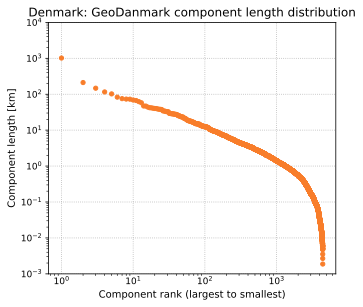

In [23]:
# Zipf plot of component lengths

set_renderer(renderer_plot)

components_length = {}

for i, c in enumerate(ref_components):
    c_length = 0
    for (u, v, l) in c.edges(data="length"):
        c_length += l
    components_length[i] = c_length

components_df = pd.DataFrame.from_dict(components_length, orient="index")
components_df.rename(columns={0: "component_length"}, inplace=True)

fig = plt.figure(figsize=pdict["fsbar_small"])
axes = fig.add_axes([0, 0, 1, 1])

axes.set_axisbelow(True)
axes.grid(True,which="major",ls="dotted")
yvals = sorted(list(components_df["component_length"] / 1000), reverse = True)
axes.scatter(
    x=[i+1 for i in range(len(components_df))],
    y=yvals,
    s=18,
    color=pdict["ref_base"],
)
axes.set_ylim(ymin=10**math.floor(math.log10(min(yvals))), ymax=10**math.ceil(math.log10(max(yvals))))
axes.set_xscale("log")
axes.set_yscale("log")

axes.set_ylabel("Component length [km]")
axes.set_xlabel("Component rank (largest to smallest)")
axes.set_title(area_name+": " + f"{reference_name} component length distribution")

plot_func.save_fig(fig, ref_results_plots_fp + "component_length_distribution_reference")

In [24]:
largest_cc = max(ref_components, key=len)

largest_cc_length = 0

for (u, v, l) in largest_cc.edges(data="length"):

    largest_cc_length += l

largest_cc_pct = largest_cc_length / components_df["component_length"].sum() * 100

print(
    f"The largest connected component contains {largest_cc_pct:.2f}% of the network length."
)

lcc_edges = ox.graph_to_gdfs(
    G=largest_cc, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=False
)

# Export to GPKG
lcc_edges[["edge_id", "geometry"]].to_parquet(
    ref_results_data_fp + "largest_connected_component.parquet"
)

The largest connected component contains 11.73% of the network length.


### Largest connected component

In [25]:
# Plot of largest connected component

if plot_static_maps:
    
    set_renderer(renderer_map)
    fig, ax = plt.subplots(1, 1, figsize=pdict["fsmap"])
    ref_edges_simplified.plot(ax=ax, color = pdict["base"], linewidth = 1.5, label = "All smaller components")
    lcc_edges.plot(ax=ax, color=pdict["ref_base"], linewidth = 2, label = "Largest connected component")
    grid.plot(ax=ax,alpha=0)
    ax.set_axis_off()
    ax.set_title(area_name + f": {reference_name} largest connected component")
    ax.legend()

    cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)
    cx.add_attribution(ax=ax, text=f"(C) {reference_name}")
    txt = ax.texts[-1]
    txt.set_position([1,0.00])
    txt.set_ha('right')
    txt.set_va('bottom')

    plot_func.save_fig(fig, ref_results_static_maps_fp + f"largest_conn_comp_reference")

In [26]:
# Save plot without basemap for potential report titlepage

set_renderer(renderer_map)
fig, ax = plt.subplots(1, 1, figsize=pdict["fsmap"])
ref_edges_simplified.plot(ax=ax, color = pdict["base"], linewidth = 1.5, label = "Disconnected components")
lcc_edges.plot(ax=ax, color=pdict["ref_base"], linewidth = 2, label = "Largest connected component")
ax.set_axis_off()

plot_func.save_fig(fig, ref_results_static_maps_fp + "titleimage",plot_res="high")
plt.close()

### Missing links

In the plot of potential missing links between components, all edges that are within the specified distance of an edge on another component are plotted. The gaps between disconnected edges are highlighted with a marker.
The map thus highlights edges which, despite being in close proximity of each other, are disconnected and where it thus would not be possible to bike on cycling infrastructure between the edges.

<div class="alert alert-block alert-info">
<b>User configurations</b>
<br>
<br>
In the analysis of potential missing links between components, the user must define the threshold for when the distance between two components is considered to be low enough that a digitization error is suspected.
</div>

In [27]:
# DEFINE MAX BUFFER DISTANCE BETWEEN COMPONENTS CONSIDERED A GAP/MISSING LINK
component_min_distance = 10

assert isinstance(component_min_distance, int) or isinstance(
    component_min_distance, float
), print("Setting must be integer or float value!")

print(f"Running analysis with component distance threshold of {component_min_distance} meters.")

Running analysis with component distance threshold of 10 meters.


In [28]:
component_gaps = eval_func.find_adjacent_components(
    components=ref_components,
    buffer_dist=component_min_distance,
    crs=study_crs,
    edge_id="edge_id",
)
component_gaps_gdf = gpd.GeoDataFrame.from_dict(
    component_gaps, orient="index", geometry="geometry", crs=study_crs
)

edge_ids = set(
    component_gaps_gdf["edge_id" + "_left"].to_list()
    + component_gaps_gdf["edge_id" + "_right"].to_list()
)

edge_ids = [int(i) for i in edge_ids]
edges_with_gaps = ref_edges_simplified.loc[ref_edges_simplified.edge_id.isin(edge_ids)]

In [29]:
# Save to csv
pd.DataFrame(edge_ids, columns=["edge_id"]).to_csv(
    ref_results_data_fp + f"component_gaps_edges_{component_min_distance}.csv",
    index=False,
)

component_gaps_gdf.to_file(
    ref_results_data_fp + f"component_gaps_centroids_{component_min_distance}.gpkg"
)

In [30]:
# Interactive plot of adjacent components

if plot_interactive_maps and len(component_gaps) > 0:

    simplified_edges_folium = plot_func.make_edgefeaturegroup(
        gdf=ref_edges_simplified,
        mycolor=pdict["ref_base"],
        myweight=pdict["line_base"],
        nametag="All edges",
        show_edges=True,
    )

    component_issues_edges_folium = plot_func.make_edgefeaturegroup(
        gdf=edges_with_gaps,
        mycolor=pdict["ref_emp"],
        myweight=pdict["line_emp"],
        nametag="Adjacent disconnected edges",
        show_edges=True,
    )

    component_issues_gaps_folium = plot_func.make_markerfeaturegroup(
        gdf=component_gaps_gdf, nametag="Component gaps", show_markers=True
    )

    m = plot_func.make_foliumplot(
        feature_groups=[
            simplified_edges_folium,
            component_issues_edges_folium,
            component_issues_gaps_folium,
        ],
        layers_dict=folium_layers,
        center_gdf=ref_nodes_simplified,
        center_crs=ref_nodes_simplified.crs,
    )

    bounds = plot_func.compute_folium_bounds(ref_nodes_simplified)
    m.fit_bounds(bounds)
    m.save(ref_results_inter_maps_fp + f"component_gaps_{component_min_distance}_reference.html")

    display(m)

In [31]:
if plot_interactive_maps:
    if len(component_gaps) > 0:
        print("Interactive map saved at " + ref_results_inter_maps_fp.lstrip("../") + f"component_gaps_{component_min_distance}_reference.html")
    else:
        print("There are no component gaps to plot.")

### Component connectivity

Here we visualize differences between how many cells can be reached from each cell. This is a crude measure for network connectivity but has the benefit of being computationally cheap and thus able to quickly highlight stark differences in network connectivity.

In [32]:
ref_components_cell_count = eval_func.count_component_cell_reach(
    components_df, grid, "component_ids_ref"
)
grid["cells_reached_ref"] = grid["component_ids_ref"].apply(
    lambda x: eval_func.count_cells_reached(x, ref_components_cell_count)
    if x != ""
    else 0
)

grid["cells_reached_ref_pct"] = grid.apply(
    lambda x: np.round((x.cells_reached_ref / len(grid)) * 100, 2), axis=1
)

grid.loc[grid["cells_reached_ref_pct"] == 0, "cells_reached_ref_pct"] = np.NAN

In [33]:
# Plot percent of cells reachable

if plot_static_maps:
    
    set_renderer(renderer_map)

    fig, ax = plt.subplots(1, 1, figsize=pdict["fsmap"])

    # norm for color bars
    cbnorm_reach = colors.Normalize(vmin=0, vmax=100)
    cbnorm_reach_diff = colors.Normalize(vmin=-100, vmax=100)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3.5%", pad="1%")

    grid.plot(
        cax=cax,
        ax=ax,
        column="cells_reached_ref_pct",
        legend=True,
        cmap=pdict["seq"],
        norm=cbnorm_reach,
        alpha=pdict["alpha_grid"],
    )

    ref_edges_simplified.plot(ax=ax, color=pdict["ref_emp"], linewidth=pdict["line_base"])

    # add no data patches
    grid[grid["count_ref_edges"].isnull()].plot(
        cax=cax,
        ax=ax,
        facecolor=pdict["nodata_face"],
        edgecolor=pdict["nodata_edge"],
        linewidth= pdict["line_nodata"],
        hatch=pdict["nodata_hatch"],
        alpha=pdict["alpha_nodata"],
    )

    ax.legend(handles=[nodata_patch], loc="upper right")

    cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)
    cx.add_attribution(ax=ax, text=f"(C) {reference_name}")
    txt = ax.texts[-1]
    txt.set_position([1,0.00])
    txt.set_ha('right')
    txt.set_va('bottom')
    ax.set_title(area_name+f": {reference_name} percent of cells reachable")
    ax.set_axis_off()

    plot_func.save_fig(fig,ref_results_static_maps_fp + "percent_cells_reachable_grid_reference")

In [34]:
components_results = {}
components_results["component_count"] = len(ref_components)
components_results["largest_cc_pct_size"] = largest_cc_pct
components_results["largest_cc_length"] = largest_cc_length
components_results["count_component_gaps"] = len(component_gaps)

## Summary

In [35]:
summarize_results = {**density_results, **components_results}

summarize_results["count_dangling_nodes"] = len(dangling_nodes)
summarize_results["count_overshoots"] = len(overshoots)
summarize_results["count_undershoots"] = len(undershoot_nodes)

# Add total node count and total infrastructure length
summarize_results["total_nodes"] = len(ref_nodes_simplified)
summarize_results["total_length"] = ref_edges_simplified.infrastructure_length.sum() / 1000

summarize_results_df = pd.DataFrame.from_dict(summarize_results, orient="index")
summarize_results_df.rename({0: " "}, axis=1, inplace=True)

# Convert length to km
summarize_results_df.loc["largest_cc_length"] = (
    summarize_results_df.loc["largest_cc_length"] / 1000
)

summarize_results_df = summarize_results_df.reindex([
    'total_length',
    'protected_density_m_sqkm',
    'unprotected_density_m_sqkm',
    'mixed_density_m_sqkm',
    'edge_density_m_sqkm',
    'total_nodes',
    'count_dangling_nodes',
    'node_density_count_sqkm',
    'dangling_node_density_count_sqkm',
    'count_overshoots',
    'count_undershoots',
    'component_count',
    'largest_cc_length',
    'largest_cc_pct_size', 
    'count_component_gaps'
     ])

rename_metrics = {
    "total_length": "Total infrastructure length (km)",
    "total_nodes": "Nodes",
    "edge_density_m_sqkm": "Bicycle infrastructure density (m/km2)",
    "node_density_count_sqkm": "Nodes per km2",
    "dangling_node_density_count_sqkm": "Dangling nodes per km2",
    "protected_density_m_sqkm": "Protected bicycle infrastructure density (m/km2)",
    "unprotected_density_m_sqkm": "Unprotected bicycle infrastructure density (m/km2)",
    "mixed_density_m_sqkm": "Mixed protection bicycle infrastructure density (m/km2)",
    "component_count": "Components",
    "largest_cc_pct_size": "Largest component's share of network length",
    "largest_cc_length": "Length of largest component (km)",
    "count_component_gaps": "Component gaps",
    "count_dangling_nodes": "Dangling nodes",
    "count_overshoots": "Overshoots",
    "count_undershoots": "Undershoots",
}

summarize_results_df.rename(rename_metrics, inplace=True)
summarize_results_df.style.pipe(format_ref_style)

,
Total infrastructure length (km),"8,676"
Protected bicycle infrastructure density (m/km2),92
Unprotected bicycle infrastructure density (m/km2),95
Mixed protection bicycle infrastructure density (m/km2),0
Bicycle infrastructure density (m/km2),187
Nodes,"51,224"
Dangling nodes,"11,218"
Nodes per km2,1
Dangling nodes per km2,0
Overshoots,99


## Save results

In [36]:
all_results = {}

all_results["network_density"] = density_results
all_results["count_overshoots"] = len(overshoots)
all_results["count_undershoots"] = len(undershoot_nodes)
all_results["dangling_node_count"] = len(dangling_nodes)
all_results["simplification_outcome"] = simplification_results
all_results["component_analysis"] = components_results

with open(ref_intrinsic_fp, "w") as outfile:
    json.dump(all_results, outfile)

# Save summary dataframe
summarize_results_df.to_csv(
    ref_results_data_fp + "intrinsic_summary_results.csv", index=True
)

# Save grid with results
with open(ref_intrinsic_grid_fp, "wb") as f:
    pickle.dump(grid, f)

***

In [37]:
from time import strftime
print("Time of analysis: " + strftime("%a, %d %b %Y %H:%M:%S"))

Time of analysis: Tue, 14 Mar 2023 13:28:22
